<a href="https://colab.research.google.com/github/saraHuang/LLM_study/blob/main/%E6%89%8B%E6%8A%8A%E6%89%8B%E6%95%99%E4%BD%A0%E8%A8%93%E7%B7%B4_AI%EF%BC%9A%E7%94%A8_Unsloth_%E5%92%8C_LoRA_%E5%BE%AE%E8%AA%BF_Qwen2_5_VL_%E7%9C%8B%E6%87%82%E6%89%8B%E5%AF%AB%E6%95%B8%E5%AD%B8%E5%85%AC%E5%BC%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0.介紹

哈囉！歡迎來到這次的教學。今天我們要一起動手做的，是**微調**一個非常強大的視覺語言模型（Vision-Language Model）—— **Qwen2.5-VL**。我們的目標是教這個模型學會「看圖說故事」，但說的不是一般的故事，而是把圖片裡的數學公式，精準地轉換成電腦看得懂的 **LaTeX 格式**。

## 作者聯絡方式與社群媒體

如果您有任何疑問或想要進一步交流， 也歡迎私訊聯絡我，或隨時關注我的社群媒體：

* **GitHub**： [我的 GitHub 連結](https://github.com/Heng-xiu)  
* **Hugging Face**： [我的 Hugging Face 連結](https://huggingface.co/Heng666)
* **部落格**： [我的 Medium 連結](https://r23456999.medium.com/)

感謝大家的支持，也希望透過這些管道與更多對生成式 AI、Agentic AI System  
或其他技術領域感興趣的朋友們進行討論和交流！

<div class="align-center">
  <a href="https://ko-fi.com/hengshiousheu"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a>
</div>



❤️ Created by [hengshiousheu](www.linkedin.com/in/heng-shiou-sheu-85321b70). 建立日期：2025/06/08

# 1.專案簡介與環境設定

在開始之前，我們需要先安裝一些必要的工具。下面這段程式碼會幫我們把 unsloth 這個祕密武器安裝好。unsloth 可以讓我們的模型訓練速度**快上 2 倍**，而且還**更省記憶體**。


In [ ]:
%%capture
# 這邊會判斷你是在 Colab 環境還是在本機執行
# 如果是在 Colab，它會用特別的方式安裝，確保所有東西都相容
# 如果是本機，就用標準的 pip install unsloth 就可以囉

import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    !pip install transformers==4.51.3
    !pip install --no-deps unsloth

##1.1.載入模型與 Tokenizer

好，工具安裝完畢！接下來，我們要從 Hugging Face 模型庫把今天的主角——`Qwen2.5-VL-7B-Instruct-bnb-4bit` 給請出來。

我們這裡會使用 unsloth 提供的 `FastVisionModel`，這是一個優化過的版本。

特別注意一下 `load_in_4bit = True` 這個設定，這是一個節省記憶體的關鍵！它會用 4-bit 的精度來載入模型，讓我們就算在 Google Colab 這種免費的 GPU 環境下，也能順利地微調這個擁有 70 億參數的龐然大物。

In [ ]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 從 Hugging Face 下載並載入模型和 tokenizer
# tokenizer 的作用是把文字轉換成模型看得懂的數字 ID
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit",
    load_in_4bit = True, # 使用 4-bit 量化，大幅降低記憶體需求
    use_gradient_checkpointing = "unsloth", # 這個選項可以幫助處理長文本或圖片，進一步節省記憶體
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.6.5: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.97G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/5.80k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [ ]:
# @title 展開查看其他可微調的模型
# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

##1.2.設定 LoRA (低秩適應) 進行高效微調

直接訓練整個大模型太慢也太耗資源了，所以我們要用一個叫做 **LoRA (Low-Rank Adaptation)** 的技術。

你可以把它想像成是給模型裝上一個小小的「外掛」。我們不去動原本模型那幾十億個參數，只訓練這個小外掛（大概只佔總參數的 1%）。這樣一來，訓練速度會快非常多，而且效果一樣好！這就是所謂的 `參數高效微調 (Parameter-Efficient Finetuning, PEFT)`。

In [ ]:
# 使用 get_peft_model 來為我們的模型加上 LoRA 適配器(adapter)
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # True 如果我們要微調視覺層
    finetune_language_layers   = True, # True 如果我們也要微調語言層
    finetune_attention_modules = True, # True 如果注意力模組也調
    finetune_mlp_modules       = True, # True 如果MLP 模組也全上

    r = 8,           # LoRA 的秩，數字越大，理論上能學得越複雜，但也要小心過擬合
    lora_alpha = 16,  # LoRA 的縮放因子，通常建議設成 r 的兩倍
    lora_dropout = 0, # Dropout 比率，設 0 代表不使用
    bias = "none",    # 是否訓練 bias，"none" 表示不訓練
    random_state = 3407, # 固定的隨機種子，讓每次實驗結果可以重現
    use_rslora = False,  # 是否使用 Rank Stabilized LoRA
    loftq_config = None, # 是否使用 LoftQ
    target_modules = ['down_proj', 'o_proj', 'k_proj', 'q_proj', 'gate_proj', 'up_proj', 'v_proj'], # 指定要應用 LoRA 的模組層
)

> unsloth 可以讓我們選擇只微調模型的視覺部分、只微調語言部分，或是兩者都調！你甚至可以更細緻地選擇只動「注意力層」或「MLP 層」。這裡我們就大方一點，全部都給它開下去！

#2.準備資料集

模型和訓練方式都準備好了，現在該處理「教材」了。我們要用一個專門的資料集，裡面包含了很多手寫數學公式的圖片，以及它們對應的 LaTeX 程式碼。

我們的任務，就是讓模型學會看著左邊的圖片，寫出右邊的 LaTeX。

完整的資料集可以在[這裡](https://huggingface.co/datasets/linxy/LaTeX_OCR). 找到，但為了快速展示，我們只取[其中一小部分（3000筆）](https://huggingface.co/datasets/unsloth/LaTeX_OCR)來做訓練。

In [ ]:
# 從 Hugging Face Hub 載入資料集
# 我們只取 "train" split 的前 3000 筆樣本

from datasets import load_dataset
dataset = load_dataset("unsloth/LaTeX_OCR", split = "train[:3000]")

README.md:   0%|          | 0.00/519 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/344M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/38.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/68686 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7632 [00:00<?, ? examples/s]

> 如果下載時出現錯誤資訊如 `Loading a dataset cached in a LocalFileSystem is not supported.`，請確認安裝是否符合 `pip install "datasets>=3.4.1"`

##2.1 快速預覽一下資料

俗話說，知己知彼，百戰百勝。我們先來看看這份資料集長什麼樣子。我們來看看第 3 筆資料（在程式中索引是 2），看看它的圖片和對應的文字內容。

In [ ]:
# 顯示資料集的結構資訊
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 3000
})

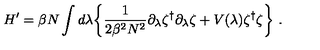

In [ ]:
# 顯示第 3 筆資料的圖片
dataset[2]["image"]

In [ ]:
# 顯示第 3 筆資料的 LaTeX 文字
dataset[2]["text"]

'H ^ { \\prime } = \\beta N \\int d \\lambda \\biggl \\{ \\frac { 1 } { 2 \\beta ^ { 2 } N ^ { 2 } } \\partial _ { \\lambda } \\zeta ^ { \\dagger } \\partial _ { \\lambda } \\zeta + V ( \\lambda ) \\zeta ^ { \\dagger } \\zeta \\biggr \\} \\ .'

##2.2 在 Jupyter 中渲染 LaTeX

In [ ]:
from IPython.display import display, Math, Latex

# 取得 LaTeX 字串
latex = dataset[2]["text"]

# 使用 Math 函式來顯示它
display(Math(latex))

<IPython.core.display.Math object>

##2.3 將資料轉換成對話格式

要微調視覺語言模型，我們需要把資料整理成一個特定的「對話格式」(Chat Template)。這個格式能讓模型清楚地知道，使用者的問題是什麼（包含文字和圖片），以及它應該要如何回答。

格式長得像下面這樣，一個使用者 (`user`) 的提問，後面跟著一個助理 (`assistant`) 的回答：

```
[
  { "role": "user",
    "content": [{"type": "text",  "text": "你的問題"}, {"type": "image", "image": 你的圖片}]
  },
  { "role": "assistant",
    "content": [{"type": "text",  "text": "模型的標準答案"}]
  },
]
```

我們來定義一個函式，把我們原本的資料集轉換成這個格式。

In [ ]:
# 這是一個固定的指令，告訴模型要做什麼
instruction = "Write the LaTeX representation for this image."

# 定義轉換函式
def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction}, # 使用者的文字指令
            {"type" : "image", "image" : sample["image"]}  # 使用者提供的圖片
          ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["text"]} # 模型的標準答案
          ]
        },
    ]
    # 最後回傳一個包含 "messages" 鍵的字典
    return { "messages" : conversation }

現在，我們用剛剛定義的函式，把整個資料集都轉換成新的對話格式。

In [ ]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

我們來檢查一下轉換後的第一筆資料，看看格式是不是跟我們預期的一樣。

In [ ]:
# 顯示轉換後的第一筆資料
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write the LaTeX representation for this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x40>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': '{ \\frac { N } { M } } \\in { \\bf Z } , { \\frac { M } { P } } \\in { \\bf Z } , { \\frac { P } { Q } } \\in { \\bf Z }'}]}]}

#3.推論微調前，先看看模型的實力

在開始訓練之前，我們很好奇，這個模型在「零樣本（zero-shot）」的情況下，也就是完全沒訓練過我們的資料時，表現得如何？

我們用跟剛剛一樣的第 3 張圖來考考它。

In [ ]:
# 將模型切換到「推論模式」
FastVisionModel.for_inference(model)

# 準備圖片和指令
image = dataset[2]["image"]
instruction = "Write the LaTeX representation for this image."

# 構建輸入格式
messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]

# 使用 tokenizer 將對話模板應用上去
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)

# 將圖片和文字都轉換成模型輸入的張量 (tensors)，並放到 GPU 上
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

# 使用 TextStreamer 可以讓模型的輸出一個字一個字地顯示，很有趣！
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)

# 開始生成！
# use_cache=True 會快取一些計算結果，加速生成
# temperature 和 min_p 是用來控制生成結果的隨機性和多樣性的參數
result = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

```latex
H' = \beta N \int d\lambda \left\{ \frac{1}{2 \beta^2 \mu^2} \partial_\lambda \zeta^\dagger \partial_\lambda \zeta + V(\lambda) \zeta^\dagger \zeta \right\}.
```<|im_end|>


In [ ]:
# @title 3.1 視覺化比較兩者差異

import difflib
from IPython.display import display, HTML

# 原始 LaTeX 公式
original_latex = r"H^{\prime} = \beta N \int d\lambda \biggl\{ \frac{1}{2\beta^{2} N^{2}} \partial_{\lambda} \zeta^{\dagger} \partial_{\lambda} \zeta + V(\lambda) \zeta^{\dagger} \zeta \biggr\} \ ."

# 推論結果 LaTeX 公式
inferred_latex = r"H' = \beta N \int d\lambda \left\{ \frac{1}{2\beta^2 N^{2}} \partial_{\lambda}\zeta^{c} \partial_{\lambda}\zeta + V(\lambda) \zeta^{c} \zeta \right\} ."

# 函數：比較兩個 LaTeX 字串並高亮差異
def highlight_latex_diff(original, inferred):
    differ = difflib.Differ()
    diff = list(differ.compare(original.split(), inferred.split()))

    original_highlighted = []
    inferred_highlighted = []

    for item in diff:
        if item.startswith('  '):  # 相同部分
            original_highlighted.append(item[2:])
            inferred_highlighted.append(item[2:])
        elif item.startswith('- '):  # 原始獨有
            original_highlighted.append(r"<span style='color:red'>" + item[2:] + r"</span>")
        elif item.startswith('+ '):  # 推論獨有
            inferred_highlighted.append(r"<span style='color:blue'>" + item[2:] + r"</span>")

    original_latex_highlighted = " ".join(original_highlighted)
    inferred_latex_highlighted = " ".join(inferred_highlighted)

    return original_latex_highlighted, inferred_latex_highlighted

# 函數：顯示文字差異
def display_text_diff(original, inferred):
    differ = difflib.Differ()
    diff = list(differ.compare(original.split(), inferred.split()))
    diff_text = "\n".join(diff)
    display(HTML("<pre style='font-size: 14px;'>" + diff_text + "</pre>"))

# 高亮差異並準備 HTML 渲染
original_highlighted, inferred_highlighted = highlight_latex_diff(original_latex, inferred_latex)

# 使用 HTML 和 MathJax 渲染 LaTeX，確保載入 color 擴展
display(HTML("""
<script type='text/x-mathjax-config'>
MathJax.Hub.Config({
  tex2jax: {inlineMath: [['$','$'], ['\\(','\\)']]},
  TeX: { extensions: ['color.js'] }
});
</script>
<h3>原始公式 (紅色為差異部分)</h3>
<div style='font-size: 16px;'>$$""" + original_highlighted + """$$</div>
<h3>推論公式 (藍色為差異部分)</h3>
<div style='font-size: 16px;'>$$""" + inferred_highlighted + """$$</div>
"""))

你會發現，未經微調的模型可能回答得不錯，但格式或細節上可能跟我們的標準答案有點出入。這就是我們接下來要透過微調來改善的地方！

#4.開始訓練！

重頭戲來了！我們要使用 Hugging Face TRL (Transformer Reinforcement Learning) 函式庫裡的 `SFTTrainer` (Supervised Fine-tuning Trainer) 來訓練我們的模型。

`SFTTrainer` 是一個超方便的工具，我們只要把模型、tokenizer、資料集和一些訓練參數都設定好，它就會自動幫我們處理好所有訓練的細節。

> 這裡我們特別要用 unsloth 提供的 UnslothVisionDataCollator，這是專為視覺任務設計的資料整理器，記得一定要用它！

參數設定的部分：

- `num_train_epochs = 1`: 我們讓模型完整地學習資料集一次。
- `per_device_train_batch_size = 1`: 每個 GPU 裝置一次處理一張圖。
- `gradient_accumulation_steps = 4`: 梯度累計步數。這是一個小技巧，實際上的批次大小會是 1 * 4 = 4，可以在不增加太多記憶體的情況下，達到使用更大批次大小的效果。
- `optim = "adamw_8bit"`: 使用 8-bit 的優化器，這也是一個節省記憶體的好方法。



In [ ]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

# 將模型切換回「訓練模式」
FastVisionModel.for_training(model)

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # 視覺任務微調必用！
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 4,
        warmup_steps = 10, # 學習率預熱步數
        max_steps = 200, # 如果你想跑完整個 epoch，但我們這邊只是想快速測試，可以設定最大步數
        num_train_epochs = 1,
        learning_rate = 2e-4, # 學習率
        fp16 = not is_bf16_supported(), # 自動判斷是否使用 fp16
        bf16 = is_bf16_supported(),     # 或 bf16
        logging_steps = 200, # 每 200 步印出一次 log
        save_strategy='steps',
        save_steps=200, # 每 200 步儲存一次模型檢查點
        save_total_limit=2, # 最多只保留 2 個檢查點
        optim = "adamw_8bit", # 使用 8-bit AdamW 優化器
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407, # 固定的隨機種子
        output_dir = "outputs", # 輸出目錄
        report_to = "none",     # 這邊可以設定 wandb (Weights and Biases) 來監控訓練過程

        # 下面這幾項是視覺微調的關鍵參數，一定要設定！
        remove_unused_columns = False,
        dataset_text_field = "", # 我們用的是 messages 格式，所以這個留空
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

Unsloth: Model does not have a default image size - using 512


> 更多關於 SFTTrainer 細節操作，可以參考[官網介紹](https://huggingface.co/docs/trl/sft_trainer)

##4.1 在開始訓練前，我們先來看看目前的 GPU 記憶體使用情況。

In [ ]:
# @title 4.1.1 顯示目前的記憶體狀態
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. 最大可用記憶體 = {max_memory} GB.")
print(f"目前已預約記憶體 = {start_gpu_memory} GB.")

GPU = Tesla T4. 最大可用記憶體 = 14.741 GB.
目前已預約記憶體 = 7.111 GB.


好了，萬事俱備，只欠東風！執行下面這行，訓練就正式開始啦！坐好，泡杯咖啡，耐心等待一下吧。整個過程大概需要 **10-15** 分鐘。

> 先下課休息 10 分鐘，順便等訓練結束。

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 3,000 | Num Epochs = 1 | Total steps = 200
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 23,794,688/7,000,000,000 (0.34% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss
200,0.253400


訓練完成！我們來看看這次訓練的成果報告，花了多少時間，以及記憶體的使用峰值是多少。你會發現，由於 unsloth 的優化，記憶體的使用量非常驚人地低！

In [ ]:
# @title 4.1.2 顯示最終的記憶體和時間統計
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"訓練總共花費 {trainer_stats.metrics['train_runtime']:.2f} 秒。")
print(
    f"也就是 {round(trainer_stats.metrics['train_runtime']/60, 2)} 分鐘。"
)
print(f"記憶體使用峰值 = {used_memory} GB.")
print(f"LoRA 訓練額外使用的記憶體 = {used_memory_for_lora} GB.")
print(f"記憶體峰值佔最大可用記憶體的 {used_percentage} %.")
print(f"LoRA 訓練額外使用記憶體佔最大可用記憶體的 {lora_percentage} %.")

訓練總共花費 782.98 秒。
也就是 13.05 分鐘。
記憶體使用峰值 = 7.111 GB.
LoRA 訓練額外使用的記憶體 = 0.0 GB.
記憶體峰值佔最大可用記憶體的 48.24 %.
LoRA 訓練額外使用記憶體佔最大可用記憶體的 0.0 %.


#5.成果驗收!

訓練結束了，是時候來驗收成果了！我們用同樣的第 3 張圖，再來考一次我們微調過的模型，看看它的回答有沒有變得更棒。

In [ ]:
# 將模型切換回推論模式
FastVisionModel.for_inference(model)

# 準備圖片和指令 (跟之前一樣)
image = dataset[2]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

# 再次使用 TextStreamer 來看看模型的回答
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

H ^ { \prime } = \beta N \int d \lambda \Biggl \{ - { 1 \over 2 \beta ^ { 2 } N ^ { 2 } } \partial _ { \lambda } \zeta ^ { * } \partial _ { \lambda } \zeta + V ( \lambda ) \zeta ^ { * } \zeta \Biggr \} \ .<|im_end|>


> 參數中採用 `min_p = 0.1` 以及 `temperature = 1.5`. 閱讀 [推特貼文](https://x.com/menhguin/status/1826132708508213629) 了解更多架構細節。

In [ ]:
# @title 5.1 視覺化比較微調模型差異

import difflib
from IPython.display import display, HTML

# 原始 LaTeX 公式
original_latex = r"H^{\prime} = \beta N \int d\lambda \biggl\{ \frac{1}{2\beta^{2} N^{2}} \partial_{\lambda} \zeta^{\dagger} \partial_{\lambda} \zeta + V(\lambda) \zeta^{\dagger} \zeta \biggr\} \ ."

# 推論結果 LaTeX 公式
inferred_latex = r"H ^ { \prime } = \beta N \int d \lambda \Biggl \{ - { 1 \over 2 \beta ^ { 2 } N ^ { 2 } } \partial _ { \lambda } \zeta ^ { * } \partial _ { \lambda } \zeta + V ( \lambda ) \zeta ^ { * } \zeta \Biggr \} \ ."

# 函數：比較兩個 LaTeX 字串並高亮差異
def highlight_latex_diff(original, inferred):
    differ = difflib.Differ()
    diff = list(differ.compare(original.split(), inferred.split()))

    original_highlighted = []
    inferred_highlighted = []

    for item in diff:
        if item.startswith('  '):  # 相同部分
            original_highlighted.append(item[2:])
            inferred_highlighted.append(item[2:])
        elif item.startswith('- '):  # 原始獨有
            original_highlighted.append(r"<span style='color:red'>" + item[2:] + r"</span>")
        elif item.startswith('+ '):  # 推論獨有
            inferred_highlighted.append(r"<span style='color:blue'>" + item[2:] + r"</span>")

    original_latex_highlighted = " ".join(original_highlighted)
    inferred_latex_highlighted = " ".join(inferred_highlighted)

    return original_latex_highlighted, inferred_latex_highlighted

# 函數：顯示文字差異
def display_text_diff(original, inferred):
    differ = difflib.Differ()
    diff = list(differ.compare(original.split(), inferred.split()))
    diff_text = "\n".join(diff)
    display(HTML("<pre style='font-size: 14px;'>" + diff_text + "</pre>"))

# 高亮差異並準備 HTML 渲染
original_highlighted, inferred_highlighted = highlight_latex_diff(original_latex, inferred_latex)

# 使用 HTML 和 MathJax 渲染 LaTeX，確保載入 color 擴展
display(HTML("""
<script type='text/x-mathjax-config'>
MathJax.Hub.Config({
  tex2jax: {inlineMath: [['$','$'], ['\\(','\\)']]},
  TeX: { extensions: ['color.js'] }
});
</script>
<h3>原始公式 (紅色為差異部分)</h3>
<div style='font-size: 16px;'>$$""" + original_highlighted + """$$</div>
<h3>推論公式 (藍色為差異部分)</h3>
<div style='font-size: 16px;'>$$""" + inferred_highlighted + """$$</div>
"""))

看到沒！這次的輸出是不是跟標準答案一模一樣了呢？這就是微調的威力！

#6.保存我們訓練好的微調模型

辛苦訓練好的模型當然要好好保存下來！

你可以選擇儲存在`本機`，或是上傳到 `Hugging Face Hub`。

In [ ]:
# 儲存在本機的 "lora_model" 資料夾
model.save_pretrained("lora_model")
tokenizer.save_pretrained("lora_model")

# 如果你想上傳到 Hugging Face Hub，可以取消下面這兩行的註解
# 注意：你需要先在 Hugging Face 網站上取得你的 token
# model.push_to_hub("你的HuggingFace使用者名稱/你的模型名稱", token = "你的TOKEN")
# tokenizer.push_to_hub("你的HuggingFace使用者名稱/你的模型名稱", token = "你的TOKEN")

[]

> 這邊我們只會儲存 LoRA 的「適配器」部分（也就是 LoRA adapters），而不是整個大模型。這樣做的好處是檔案非常小，方便分享和載入。

##6.1 Colab 上查看保存資料夾
- 點選左側資料夾圖示
- 點擊名為 `lora_model` 資料夾

##6.2 如何載入已存檔的 LoRA 模型

未來如果你想使用這個微調好的模型，就不需要再重新訓練了。只要從我們剛剛儲存的路徑`('lora_model')`載入即可。

In [ ]:
# 這邊預設是 False，如果你想實際執行載入，可以把它改成 True
if False:
    from unsloth import FastVisionModel
    # 載入模型時，直接指定你儲存的 LoRA 模型資料夾名稱
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # 指定你剛剛儲存的 LoRA 模型
        load_in_4bit = True, # 同樣用 4-bit 模式載入
    )
    # 切換到推論模式
    FastVisionModel.for_inference(model)

# 我們用第 1 張圖來測試看看載入的模型
image = dataset[0]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

\frac { N } { M } \in \mathbf { Z } , \frac { P } { Q } \in \mathbf { Z } , \frac { M } { P } \in \mathbf { Z }<|im_end|>


##6.3 儲存成 float16 格式以供部署 (例如 vLLM, Nvidia NIM)

如果你想將模型部署到正式環境，例如使用像 `vLLM` 這樣的推論伺服器，你可能會需要將 `LoRA adapters` 與基底模型合併，並儲存成標準的 `float16` 格式。

unsloth`` 也幫我們想到了這一點！

In [ ]:
# 注意：下面兩個選項你只需要選一個來執行！

# 將模型合併後儲存到本機
if False: model.save_pretrained_merged("unsloth_finetune", tokenizer,)

# 將模型合併後直接上傳到你的 Hugging Face Hub
# if False: model.push_to_hub_merged("你的HuggingFace使用者名稱/unsloth_finetune", tokenizer, token = "你的TOKEN")

恭喜你！到這裡，你已經完整地走完了使用 unsloth 高效微調 Qwen2.5-VL 模型的全部流程。希望這份更友善的筆記對你有幫助！

## 作者聯絡方式與社群媒體

如果您有任何疑問或想要進一步交流， 也歡迎私訊聯絡我，或隨時關注我的社群媒體：

* **GitHub**： [我的 GitHub 連結](https://github.com/Heng-xiu)  
* **Hugging Face**： [我的 Hugging Face 連結](https://huggingface.co/Heng666)
* **部落格**： [我的 Medium 連結](https://r23456999.medium.com/)

感謝大家的支持，也希望透過這些管道與更多對生成式 AI、Agentic AI System  
或其他技術領域感興趣的朋友們進行討論和交流！

<div class="align-center">
  <a href="https://ko-fi.com/hengshiousheu"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a>
</div>
